### Here we transform the NetCDF file into standard lists for further analyses 
#### We regrid the spatial resolution onto 2°×2°
#### Historical O${_3}$ simulations 1850-2014

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import iris
from eofs.iris import Eof

#### Prescribe the key parameters: 
##### i) target years for analysis (e.g. Y = 5 for five most recent years 2010-2014)
##### ii) ideal spatial resolutions (e.g. 180×90 grids)
###### These parameters are prescribed arbitrarily

In [2]:
Y = 5
lon = 180
lat = 90

#### Define the 1°×1° new spatial resolution for regridding (centred coordinates)

In [3]:
res_lon = 360/lon
res_lat = 180/lat
sample_points = [('longitude', np.linspace(0+res_lon/2, 360-res_lon/2, lon)),
                 ('latitude',  np.linspace(-90+res_lat/2, 90-res_lat/2, lat))]

In [4]:
sample_points

[('longitude',
  array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
          23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
          45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
          67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
          89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
         111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
         133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
         155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
         177., 179., 181., 183., 185., 187., 189., 191., 193., 195., 197.,
         199., 201., 203., 205., 207., 209., 211., 213., 215., 217., 219.,
         221., 223., 225., 227., 229., 231., 233., 235., 237., 239., 241.,
         243., 245., 247., 249., 251., 253., 255., 257., 259., 261., 263.,
         265., 267., 269., 271., 273., 275., 277., 279., 281., 283., 285.,
         2

#### Define the longitude-latitude-temporal sequence list

In [5]:
t = Y*12 ## Y years correspond to 12Y months 

lon_range = np.linspace(0+res_lon/2, 360-res_lon/2, lon)
lat_range = np.linspace(-90+res_lat/2, 90-res_lat/2, lat) 
t_range   = np.linspace(1, t, t) 
lat_mesh, t_mesh, lon_mesh = np.meshgrid(lat_range, t_range, lon_range) 

t_grid   = t_mesh.reshape(t*lon*lat, 1)
lon_grid = lon_mesh.reshape(t*lon*lat, 1)
lat_grid = lat_mesh.reshape(t*lon*lat, 1)

dataset = pd.DataFrame(lon_grid, columns = {'longitude'})
dataset['latitude'] = lat_grid
dataset['t'] = t_grid
dataset['loc'] = dataset['longitude']*1000+dataset['latitude']
dataset

,longitude,latitude,t,loc
0,1.0,-89.0,1.0,911.0
1,3.0,-89.0,1.0,2911.0
2,5.0,-89.0,1.0,4911.0
3,7.0,-89.0,1.0,6911.0
4,9.0,-89.0,1.0,8911.0
...,...,...,...,...
971995,351.0,89.0,60.0,351089.0
971996,353.0,89.0,60.0,353089.0
971997,355.0,89.0,60.0,355089.0
971998,357.0,89.0,60.0,357089.0


#### 1.1. Import surface/ambient O${_3}$

In [6]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/o3_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'o3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3 = values.reshape(t*lon*lat,1)
dataset['o3'] = o3

#### 1.2. Import surface/ambient O${_3}$ production rate 

In [7]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/o3prod_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'o3prod')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3prod = values.reshape(t*lon*lat,1)
dataset['o3prod'] = o3prod

#### 1.3. Import surface/ambient O${_3}$ loss rate

In [8]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/o3loss_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'o3loss')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3loss = values.reshape(t*lon*lat,1)
dataset['o3loss'] = o3loss

#### 2.1. Import total NO${_X}$ emission 

In [10]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/eminox_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'eminox')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
nox = values.reshape(t*lon*lat,1)
dataset['eminox'] = nox

#### 2.2. Import total VOC emission

In [11]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/emibvoc_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'emibvoc')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
voc = values.reshape(t*lon*lat,1)
dataset['emivoc'] = voc

#### 3.1. Import near-surface air temperature

In [12]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'tas')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
tas = values.reshape(t*lon*lat,1)
dataset['tas'] = tas

#### 3.2. Import ambient air humidity

In [13]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/hus_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'hus')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:,:]
data = data.collapsed('air_pressure', iris.analysis.MAX)
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hus = values.reshape(t*lon*lat,1)
dataset['hus'] = hus

#### 3.3. Import aerosol optical depth at 550 nm

In [14]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/abs550aer_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'abs550aer')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
aod = values.reshape(t*lon*lat,1)
dataset['aod'] = aod

#### 3.4. Import planetary boundary layer height

In [15]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/bldep_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'bldep')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
pbl = values.reshape(t*lon*lat,1)
dataset['bldep'] = pbl

#### 3.5. Import eastward wind speed

In [16]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/ua_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'ua')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
ua = values.reshape(t*lon*lat,1)
dataset['ua'] = ua

#### 3.6. Import northward wind speed

In [17]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/va_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'va')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
va = values.reshape(t*lon*lat,1)
dataset['va'] = va

#### 4.1. Import NO${_2}$ photolysis rate

In [18]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/jno2_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'jno2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jno2 = values.reshape(t*lon*lat,1)
dataset['jno2'] = jno2

#### 4.2. Import O${_3}$→O(${^1}$D) photolysis rate

In [19]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/photo1d_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'photo1d')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jo3 = values.reshape(t*lon*lat,1)
dataset['photo1d'] = jo3

#### 4.3. Import CH${_4}$ reaction loss rate

In [20]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/lossch4_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'lossch4')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossch4 = values.reshape(t*lon*lat,1)
dataset['lossch4'] = lossch4

#### 4.4. Import CO reaction loss rate

In [21]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/lossco_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'lossco')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossco = values.reshape(t*lon*lat,1)
dataset['lossco'] = lossco

#### 5.1. Import NO${_2}$ concentration

In [22]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/no2_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'no2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no2 = values.reshape(t*lon*lat,1)
dataset['no2'] = no2

#### 5.2. Import NO concentration

In [23]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/no_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'no')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no = values.reshape(t*lon*lat,1)
dataset['no'] = no

#### 5.3. Import OH radical concentration

In [24]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/oh_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'oh')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
oh = values.reshape(t*lon*lat,1)
dataset['oh'] = oh

#### 5.5. Import PAN reservoir concentration

In [25]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/pan_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'pan')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
pan = values.reshape(t*lon*lat,1)
dataset['pan'] = pan

#### 5.6. Import HNO${_3}$ reservoir concentration

In [26]:
data = iris.load_cube('/Volumes/Database/CMIP6/GFDL/hno3_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc', 'hno3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hno3 = values.reshape(t*lon*lat,1)
dataset['hno3'] = hno3

#### We should convert 0-360° into 180°W-180°E scheme

In [27]:
dataset_pt1 = dataset[dataset['longitude'] < 180]
dataset_pt2 = dataset[dataset['longitude'] >= 180]
dataset_pt2['longitude'] = dataset_pt2['longitude']-360
dataset_adj = dataset_pt1.append(dataset_pt2)
dataset_adj

,longitude,latitude,t,loc,o3,o3prod,o3loss,emivoc,eminox,tas,...,va,jno2,photo1d,lossch4,lossco,no2,no,oh,pan,hno3
0,1.0,-89.0,1.0,911.0,1.809749e-08,5.713640e-14,7.210932e-14,0.0,4.642811e-17,241.674698,...,-1.943326,0.010318,0.000008,3.206767e-14,1.212785e-13,5.856103e-13,1.883909e-12,1.559018e-14,4.960004e-12,1.698985e-12
1,3.0,-89.0,1.0,2911.0,1.809673e-08,5.712156e-14,7.206955e-14,0.0,4.575431e-17,241.610291,...,-1.949768,0.010319,0.000008,3.205159e-14,1.212309e-13,5.855508e-13,1.884338e-12,1.558903e-14,4.959833e-12,1.696853e-12
2,5.0,-89.0,1.0,4911.0,1.809596e-08,5.710639e-14,7.202893e-14,0.0,4.506594e-17,241.545944,...,-1.956350,0.010319,0.000008,3.203516e-14,1.211824e-13,5.854900e-13,1.884776e-12,1.558785e-14,4.959659e-12,1.694675e-12
3,7.0,-89.0,1.0,6911.0,1.809518e-08,5.709094e-14,7.198753e-14,0.0,4.436449e-17,241.481659,...,-1.963056,0.010319,0.000008,3.201842e-14,1.211329e-13,5.854280e-13,1.885222e-12,1.558664e-14,4.959480e-12,1.692456e-12
4,9.0,-89.0,1.0,8911.0,1.809437e-08,5.707516e-14,7.194526e-14,0.0,4.364817e-17,241.417480,...,-1.969905,0.010319,0.000008,3.200133e-14,1.210824e-13,5.853647e-13,1.885677e-12,1.558541e-14,4.959299e-12,1.690190e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971995,-9.0,89.0,60.0,351089.0,3.021567e-08,6.217139e-16,6.243434e-14,0.0,7.853882e-13,240.510162,...,-1.548145,0.000000,0.000000,1.490397e-16,1.411333e-15,2.854852e-10,5.221354e-11,3.293220e-17,1.157042e-10,6.393506e-12
971996,-7.0,89.0,60.0,353089.0,3.021529e-08,6.242805e-16,6.259491e-14,0.0,7.908349e-13,240.538559,...,-1.545061,0.000000,0.000000,1.494795e-16,1.415466e-15,2.866659e-10,5.255874e-11,3.302720e-17,1.157065e-10,6.404922e-12
971997,-5.0,89.0,60.0,355089.0,3.021490e-08,6.269057e-16,6.275914e-14,0.0,7.964060e-13,240.566986,...,-1.541907,0.000000,0.000000,1.499294e-16,1.419694e-15,2.878736e-10,5.291180e-11,3.312437e-17,1.157090e-10,6.416599e-12
971998,-3.0,89.0,60.0,357089.0,3.021450e-08,6.295834e-16,6.292666e-14,0.0,8.020886e-13,240.595459,...,-1.538690,0.000000,0.000000,1.503883e-16,1.424007e-15,2.891054e-10,5.327195e-11,3.322348e-17,1.157115e-10,6.428511e-12


#### Calculate the kinetic rates

In [28]:
dataset_adj['k_no_ho2']   = 3.30*10**(-12)*np.exp(270/dataset_adj['tas'])
dataset_adj['k_no_ch3o2'] = 2.30*10**(-12)*np.exp(360/dataset_adj['tas'])
dataset_adj['k_o1d_h2o']  = 1.63*10**(-10)*np.exp(60/dataset_adj['tas'])
dataset_adj['k_o3_ho2']   = 2.03*10**(-16)*(dataset_adj['tas']/300)**4.57*np.exp(693/dataset_adj['tas'])
dataset_adj['k_o3_oh']    = 1.70*10**(-12)*np.exp(-940/dataset_adj['tas'])

#### Calculate the procedural auxilliary variables 
##### where K1's are aggressive approach to use as many associated variables as possible 
##### and K2's are conservative approach to only use variables that we trust the credibility 

In [29]:
dataset_adj['K1_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no'] * dataset_adj['lossco']
dataset_adj['K1_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no'] * dataset_adj['lossch4']
dataset_adj['K1_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['photo1d'] * dataset_adj['o3'] * dataset_adj['hus']
dataset_adj['K1_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K1_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3'] * dataset_adj['lossco']

In [30]:
dataset_adj['K2_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no']
dataset_adj['K2_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no']
dataset_adj['K2_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['hus']
dataset_adj['K2_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K2_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3']

In [70]:
dataset_adj.to_csv('/Volumes/Database/Research/C7 Multivariate analysis/GFDL-ESM4_diag_2014(0316).csv', index = False)

### Map the variables to ensure correct gridding

(-90.0, 90.0)

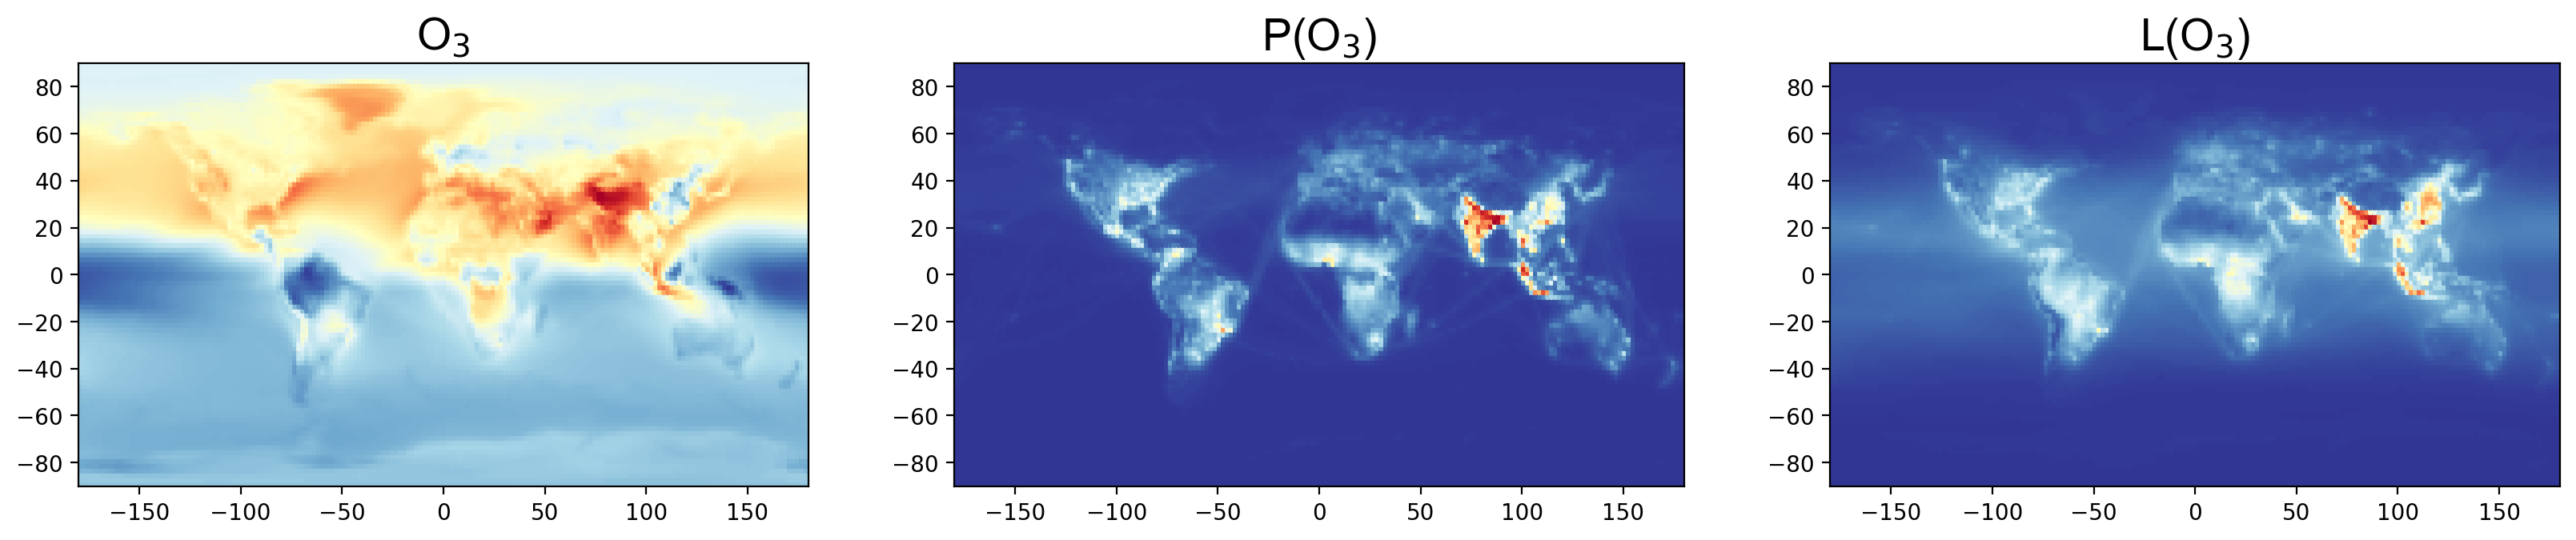

In [32]:
dataset_map = dataset_adj.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('O${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('P(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3prod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('L(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3loss'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

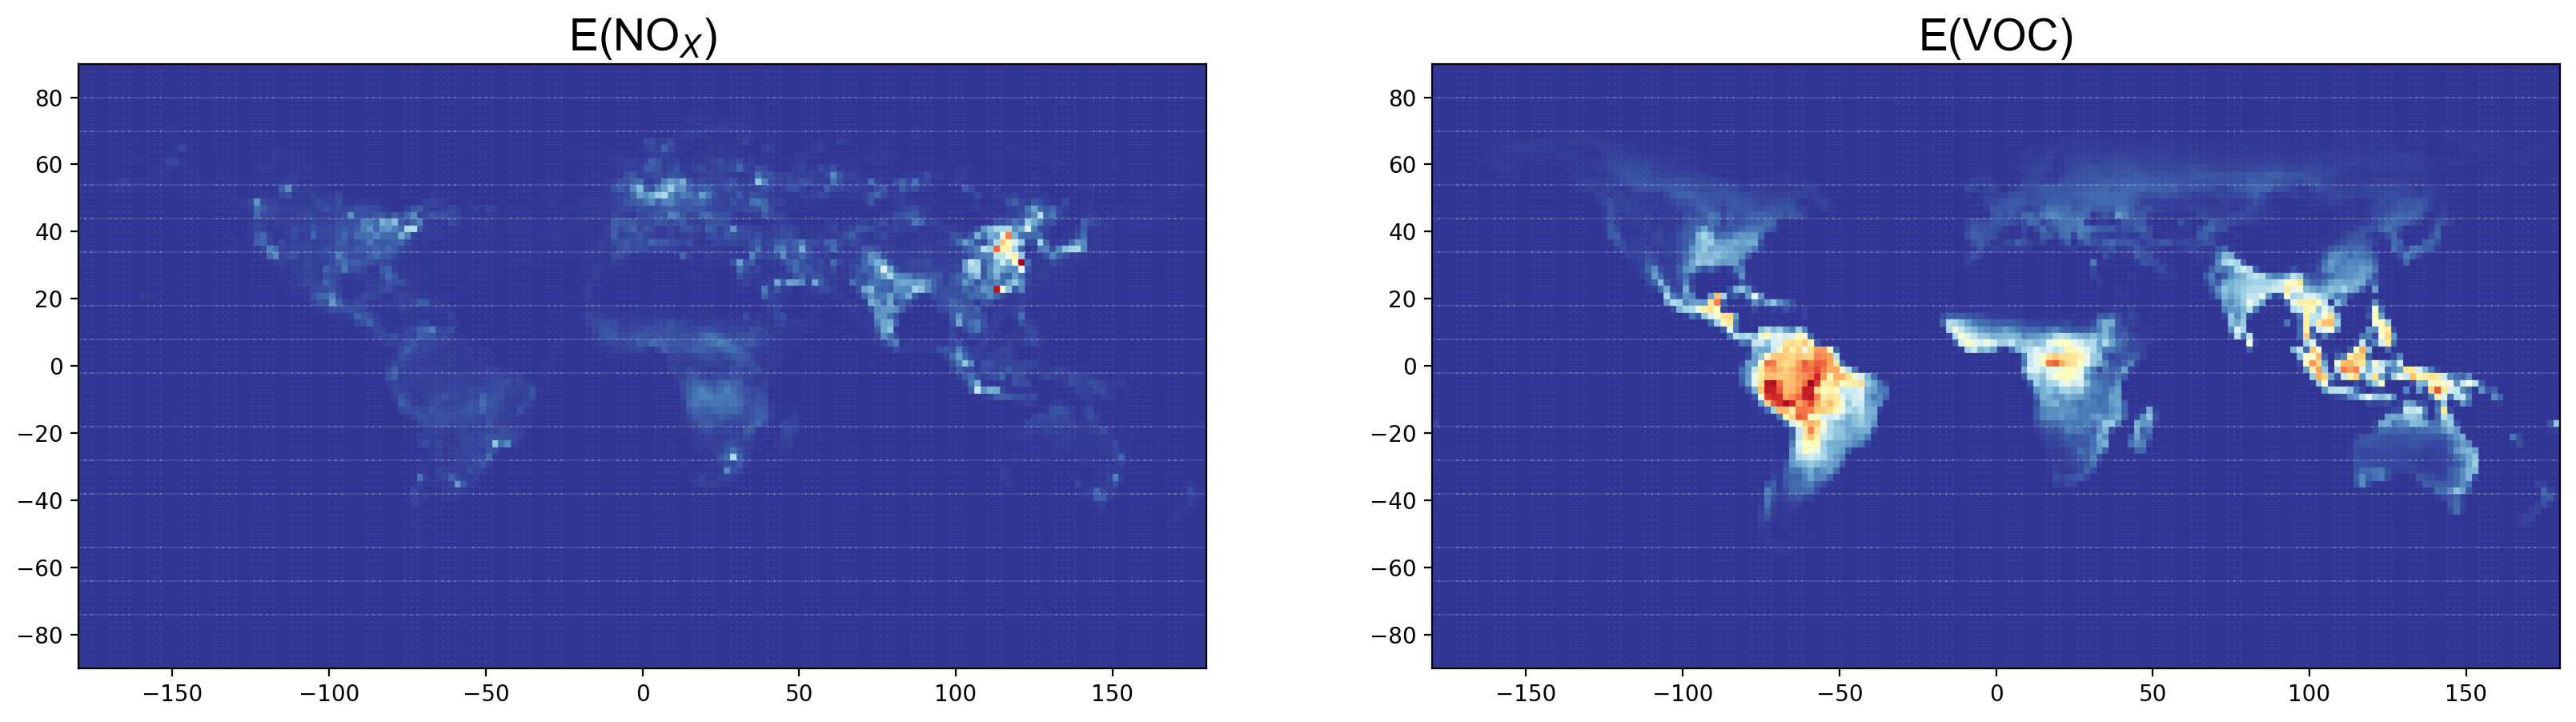

In [33]:
plt.figure(num=None, figsize=(20, 5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,2,1)
plt.title('E(NO${_X}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['eminox'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,2,2)
plt.title('E(VOC)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['emivoc'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

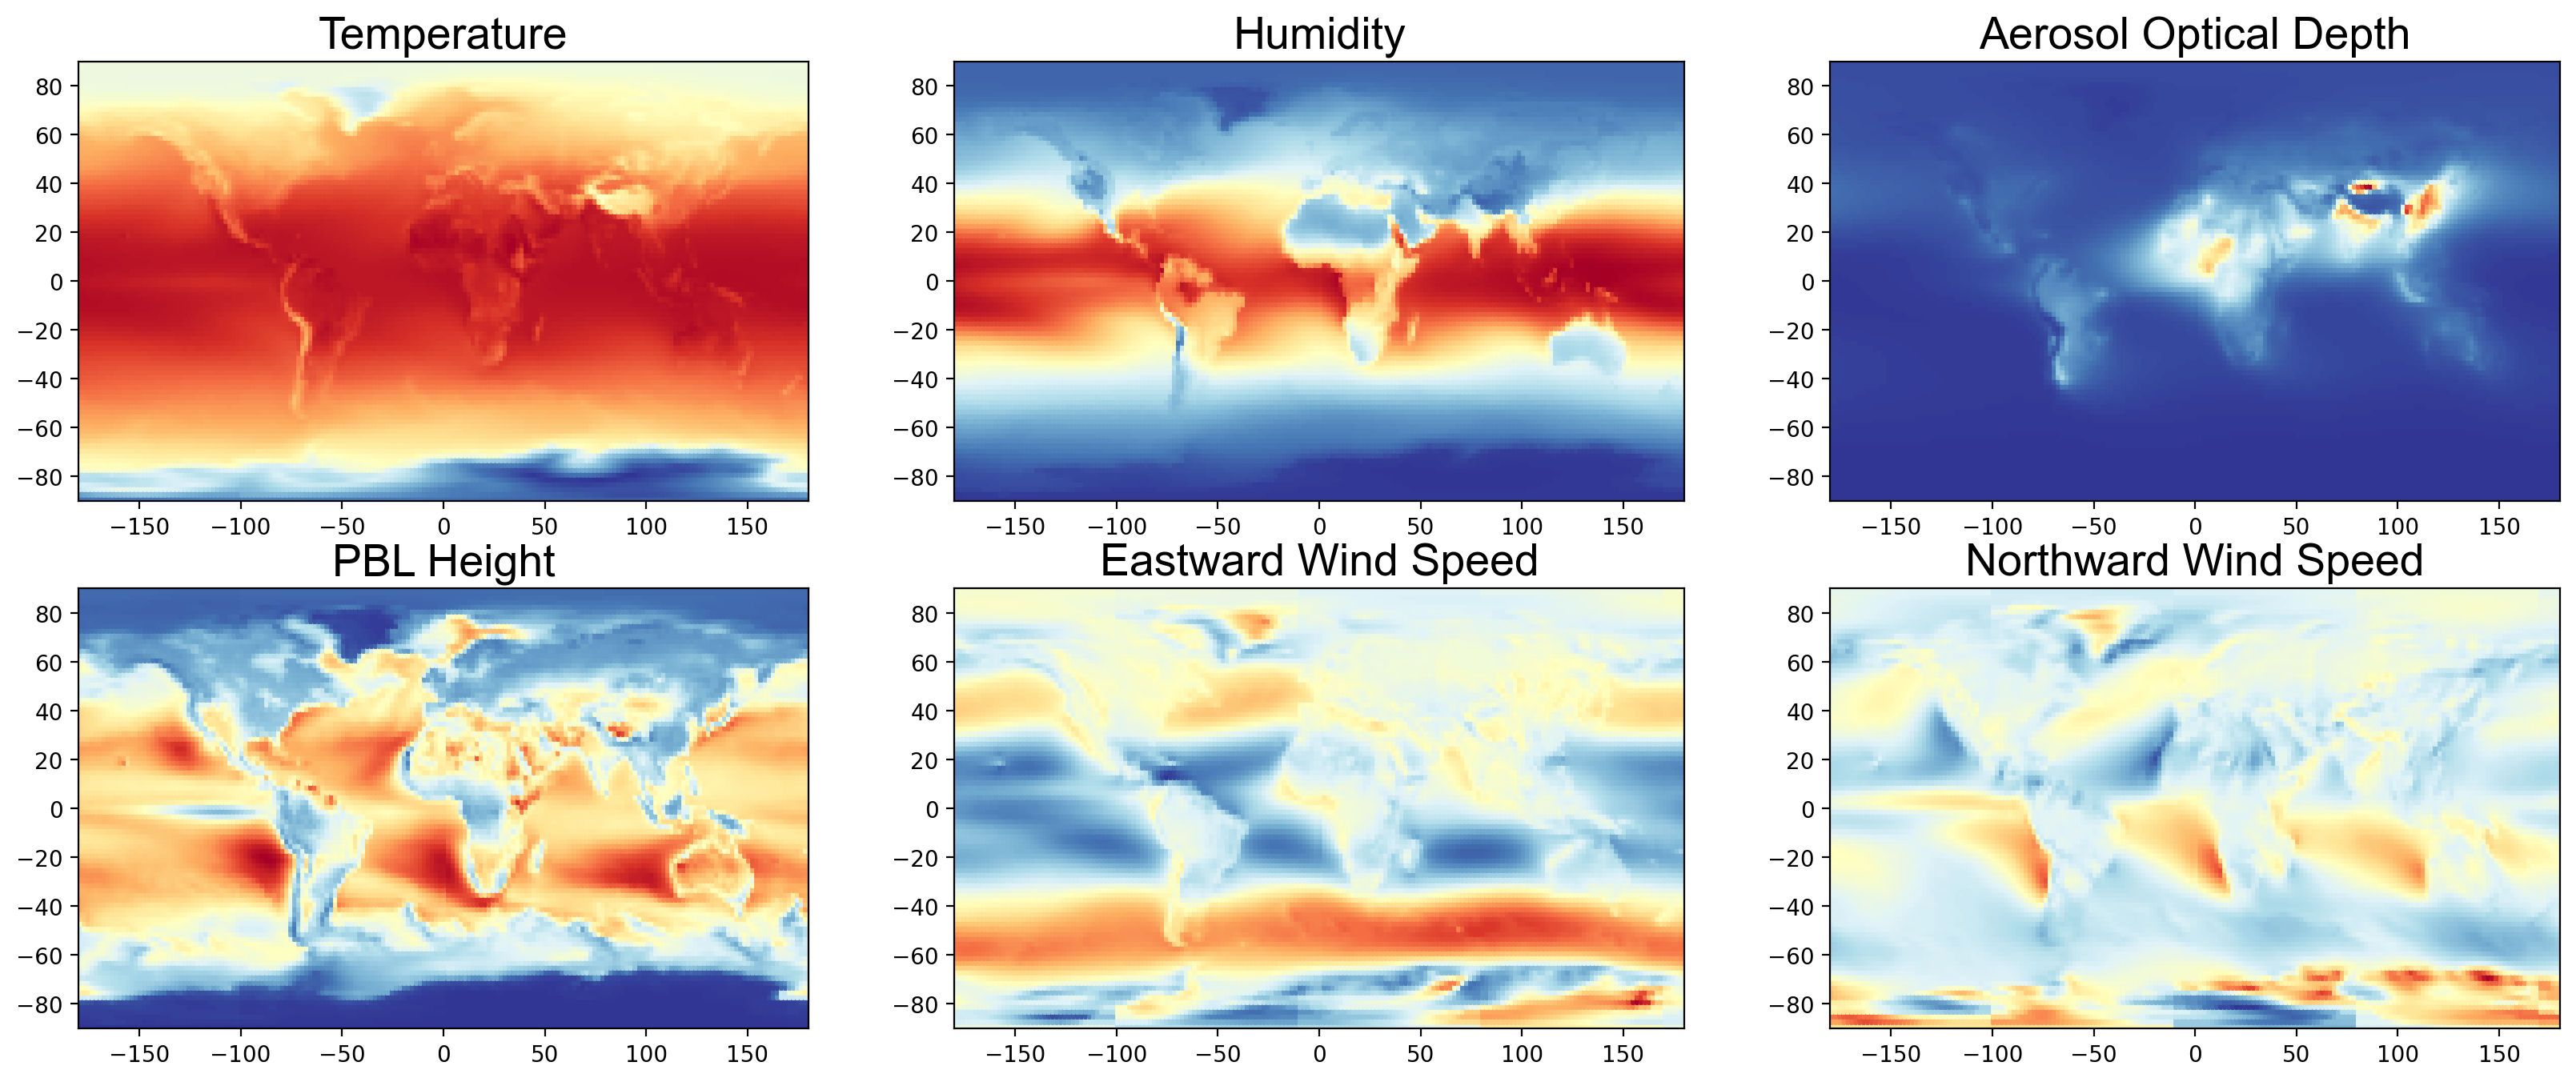

In [34]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('Temperature', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['tas'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('Humidity', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['hus'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('Aerosol Optical Depth', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['aod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('PBL Height', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['bldep'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('Eastward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ua'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('Northward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['va'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

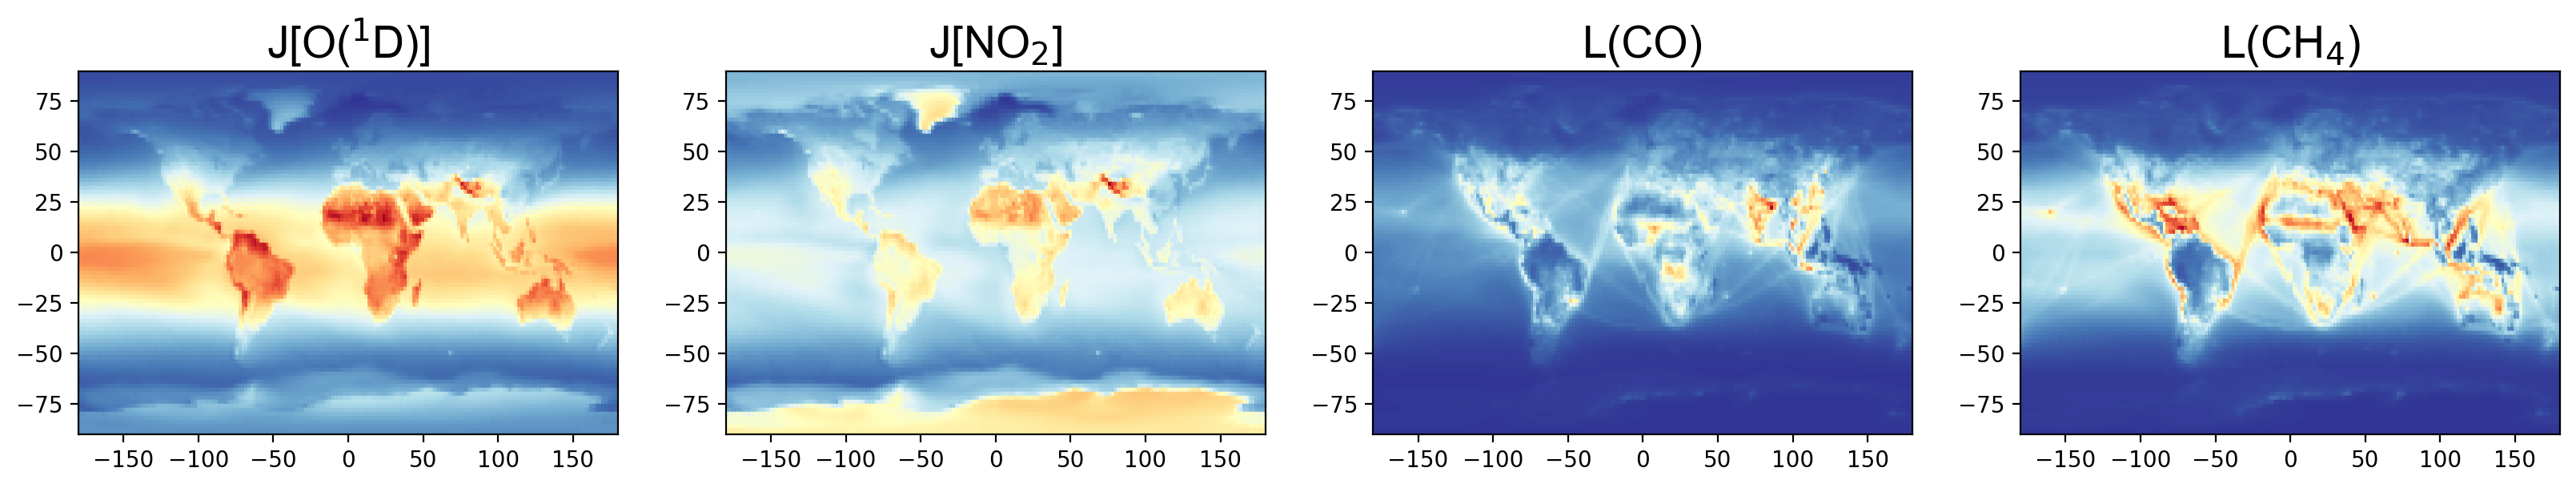

In [35]:
plt.figure(num=None, figsize=(20, 3), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(1,4,1)
plt.title('J[O(${^1}$D)]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['photo1d'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,2)
plt.title('J[NO${_2}$]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['jno2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,3)
plt.title('L(CO)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossco'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,4)
plt.title('L(CH${_4}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossch4'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

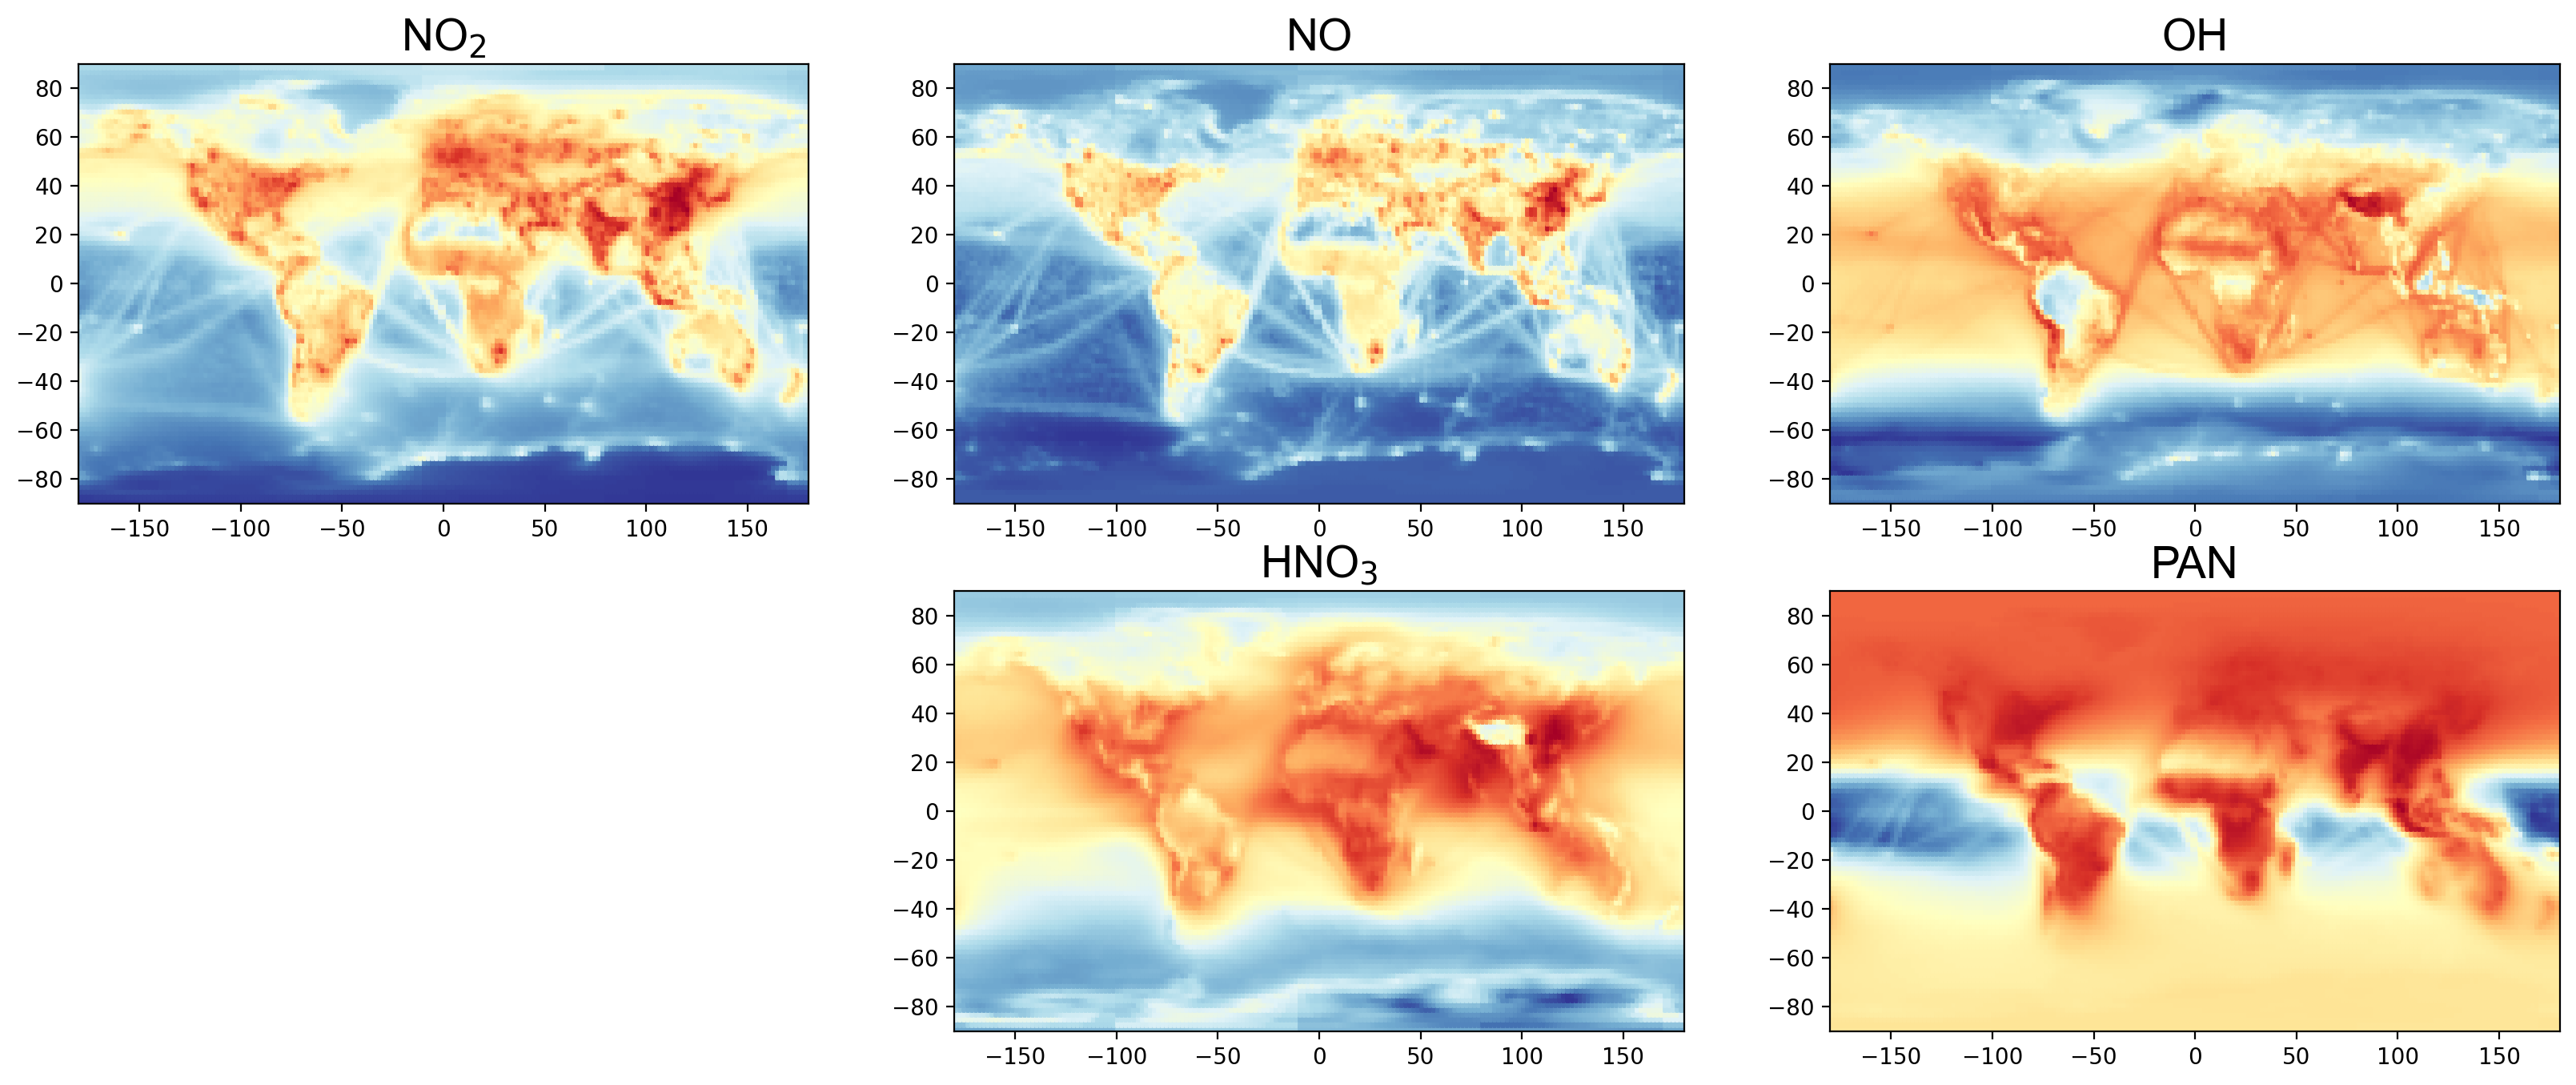

In [42]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('NO${_2}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('NO', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('OH', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['oh'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('HNO${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['hno3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('PAN', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['pan'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

#### We should now check whether each variable has been correctly extracted without any erroneous values (e.g. negative concentrations), and the sample sizes are all year×12×lon×lat. 

In [43]:
dataset_adj['eminox'].describe()

count    9.720000e+05
mean     2.732254e-12
std      9.986362e-12
min      0.000000e+00
25%      1.540037e-14
50%      1.564484e-13
75%      1.267841e-12
max      3.795486e-10
Name: eminox, dtype: float64

In [69]:
dataset_adj['emivoc'].describe()

count    9.720000e+05
mean     2.404302e-11
std      9.562240e-11
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.452092e-13
max      1.882236e-09
Name: emivoc, dtype: float64

In [45]:
dataset_adj['o3'].describe()

count    9.720000e+05
mean     2.921765e-08
std      1.028827e-08
min      2.731222e-09
25%      2.137654e-08
50%      2.834906e-08
75%      3.643590e-08
max      8.241201e-08
Name: o3, dtype: float64

In [46]:
dataset_adj['o3prod'].describe()

count    9.720000e+05
mean     2.560400e-12
std      6.318425e-12
min      1.540680e-22
25%      5.651857e-14
50%      3.949387e-13
75%      1.842559e-12
max      1.257656e-10
Name: o3prod, dtype: float64

In [47]:
dataset_adj['o3loss'].describe()

count    9.720000e+05
mean     1.123586e-12
std      1.544324e-12
min      3.312877e-17
25%      9.351278e-14
50%      5.626290e-13
75%      1.593791e-12
max      2.524595e-11
Name: o3loss, dtype: float64

In [48]:
dataset_adj['tas'].describe()

count    972000.000000
mean        278.417908
std          21.605669
min         202.501907
25%         268.131775
50%         283.214081
75%         296.088112
max         315.654022
Name: tas, dtype: float64

In [49]:
dataset_adj['hus'].describe()

count    972000.000000
mean          0.007110
std           0.005841
min           0.000051
25%           0.002134
50%           0.005468
75%           0.011783
max           0.023496
Name: hus, dtype: float64

In [50]:
dataset_adj['aod'].describe()

count    972000.000000
mean          0.008233
std           0.013638
min           0.000100
25%           0.001204
50%           0.004047
75%           0.008333
max           0.286054
Name: aod, dtype: float64

In [51]:
dataset_adj['bldep'].describe()

count    972000.000000
mean        304.098511
std         213.335617
min           0.000000
25%         119.606180
50%         302.722549
75%         461.677490
max        1339.895142
Name: bldep, dtype: float64

In [52]:
dataset_adj['ua'].describe()

count    972000.000000
mean          0.037987
std           4.218061
min         -12.843533
25%          -2.593572
50%          -0.058454
75%           2.259921
max          17.973597
Name: ua, dtype: float64

In [53]:
dataset_adj['va'].describe()

count    972000.000000
mean          0.169146
std           2.577326
min         -14.027495
25%          -1.399012
50%           0.054533
75%           1.588900
max          14.673665
Name: va, dtype: float64

In [54]:
dataset_adj['jno2'].describe()

count    972000.000000
mean          0.002352
std           0.001825
min           0.000000
25%           0.001126
50%           0.002381
75%           0.003003
max           0.011891
Name: jno2, dtype: float64

In [55]:
dataset_adj['photo1d'].describe()

count    9.720000e+05
mean     5.329757e-06
std      4.519491e-06
min      0.000000e+00
25%      8.784899e-07
50%      4.540808e-06
75%      9.203478e-06
max      2.754592e-05
Name: photo1d, dtype: float64

In [56]:
dataset_adj['no2'].describe()

count    9.720000e+05
mean     3.307798e-10
std      1.196329e-09
min      2.544652e-13
25%      7.349460e-12
50%      3.094726e-11
75%      1.645571e-10
max      3.059481e-08
Name: no2, dtype: float64

In [57]:
dataset_adj['no'].describe()

count    9.720000e+05
mean     1.689706e-10
std      1.465241e-09
min      1.695586e-19
25%      1.618814e-12
50%      7.176704e-12
75%      4.448930e-11
max      1.543609e-07
Name: no, dtype: float64

In [58]:
dataset_adj['oh'].describe()

count    9.720000e+05
mean     3.585519e-14
std      3.806339e-14
min      1.021699e-18
25%      4.772404e-15
50%      2.350294e-14
75%      5.760178e-14
max      6.658329e-13
Name: oh, dtype: float64

In [60]:
dataset_adj['hno3'].describe()

count    9.720000e+05
mean     1.180201e-10
std      2.811995e-10
min      3.644646e-15
25%      3.800778e-12
50%      2.362770e-11
75%      1.004212e-10
max      5.905914e-09
Name: hno3, dtype: float64

In [61]:
dataset_adj['pan'].describe()

count    9.720000e+05
mean     6.896529e-11
std      9.920356e-11
min      1.164084e-14
25%      4.242669e-12
50%      1.551357e-11
75%      1.224667e-10
max      1.613522e-09
Name: pan, dtype: float64

In [62]:
dataset_adj['lossco'].describe()

count    9.720000e+05
mean     8.035198e-13
std      9.407777e-13
min      9.481844e-18
25%      9.054749e-14
50%      5.071907e-13
75%      1.190823e-12
max      1.526774e-11
Name: lossco, dtype: float64

In [63]:
dataset_adj['lossch4'].describe()

count    9.720000e+05
mean     3.638485e-13
std      4.000637e-13
min      6.861315e-19
25%      2.758133e-14
50%      2.064435e-13
75%      6.212626e-13
max      2.869523e-12
Name: lossch4, dtype: float64

#### We should then check the scale of the kinetic rate coefficients with the IUPAC suggested values. 

##### The preferred value as 8.5×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [64]:
dataset_adj['k_no_ho2'].median()

8.561410403251648e-12

##### The preferred value as 7.7×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [65]:
dataset_adj['k_no_ch3o2'].median()

8.199165630340576e-12

##### The preferred value as 2.14×10$^{–10}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [66]:
dataset_adj['k_o1d_h2o'].median()

2.0146266639232636e-10

##### The preferred value as 2.0×10$^{–15}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [67]:
dataset_adj['k_o3_ho2'].median()

1.8025909995254195e-15

##### The preferred value as 7.3×10$^{–14}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [68]:
dataset_adj['k_o3_oh'].median()

6.151859760284424e-14